# Image Classification using AWS SageMaker - Inventory Monitoring at Distribution Centers

## Introduction

This notebook follows the steps to train an image classification model using AWS Sagemaker. The model can predict the number of objects in a bin image, which may contain between 1 and 5 items.

The following stages of the ML pipeline were developed on AWS Sagemaker and are explained in details in the notebooks below:
* Dataset EDA
* Models analisys
* HPO
* Debugging and profiling
* Model deployment and endpoint querying

In [2]:
# Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

# protobuf needs to be downgraded for creating a trial instance for debugging 
!pip install protobuf==3.20.0

# Numpy version needs to be downgraded to avoid the deprecation of alias np.str (introduced by NumPy 1.20) 
# This is needed for plotting the tensors of the debugging output.
!pip install "numpy<1.24"

# Import any packages that you might need
import sagemaker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.6 MB/s eta 0:00:000:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:
      Successfully uninstalled protobuf-3.19.4


## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [3]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [02:20<00:00,  8.75it/s]


100%|██████████| 2299/2299 [04:38<00:00,  8.25it/s]


100%|██████████| 2666/2666 [05:09<00:00,  8.60it/s]


100%|██████████| 2373/2373 [04:28<00:00,  8.84it/s]


100%|██████████| 1875/1875 [03:31<00:00,  8.88it/s]


## Dataset
A subset of the Amazon Bin Image dataset is used in this project (just downloaded above). Each of the five classes represents how many items are being packed for delivery in a warehouse. To get familiar with the dataset, adjust the `img_class` value below and plot some random sample images.

Image sample with 3 item:


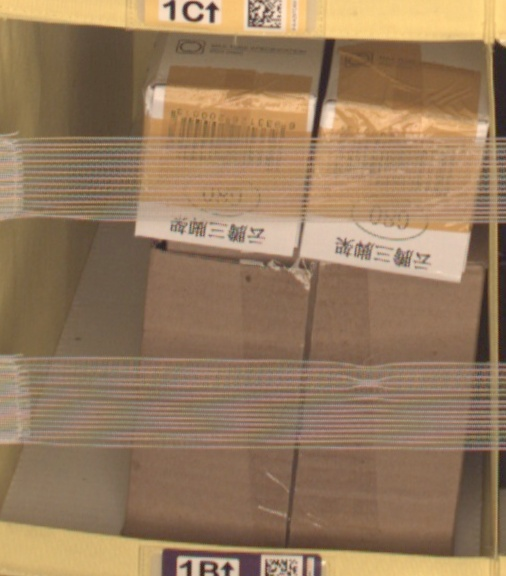

In [4]:
import random
from os import listdir
from IPython.display import Image

# Class to show
img_class = '3'

img_dir = f'train_data/{img_class}/'
image_file = random.sample(listdir(img_dir), 1)
print('Image sample with {} item:'.format(img_class))
Image(filename=img_dir+image_file[0])

After performing EDA, it was decided to perform the following:
* Dataset size undersampled to 6,140 images (train: 4,298, valid: 1,228, test: 614)
* Resize images to 224x224 pixels
* Cropping should not be applied

More details in the `Dataset_EDA.ipynb` notebook.

In [5]:
bucket = "ml-capstone-project"
prefix = "data_final"

In [6]:
#Upload the data to AWS S3
sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path="data_final", bucket=bucket, key_prefix=prefix)
print("Input data uploaded to S3: {}".format(inputs))

In [6]:
# Zip files (to be downloaded and experiment locally)
!tar -czvf train_data.tar.gz train_data

train_data/
train_data/4/
train_data/4/02573.jpg
train_data/4/101366.jpg
train_data/4/04193.jpg
...

In [7]:
# Delete folder train_data as the dataset is already uploaded to S3
!rm -r ./train_data

In [8]:
# Check data uploaded to S3 per class 

img_classes = {}
for set in ['train', 'valid', 'test']:
    for i in range(1,5+1):
        img_classes[f'Class {i}'] = !aws s3 ls s3://{bucket}/{prefix}/{set}/{i} --recursive | wc -l
        img_classes[f'Class {i}'] = int(img_classes[f'Class {i}'][0])
    print(f'{prefix}/{set}: {img_classes}')

data_final/train: {'Class 1': 859, 'Class 2': 859, 'Class 3': 859, 'Class 4': 859, 'Class 5': 859}
data_final/valid: {'Class 1': 245, 'Class 2': 245, 'Class 3': 245, 'Class 4': 245, 'Class 5': 245}
data_final/test: {'Class 1': 123, 'Class 2': 123, 'Class 3': 123, 'Class 4': 123, 'Class 5': 123}


## Model Training

An experimental benchmark was previously conducted (see results in the `Models_benchmark.ipynb` notebook). As an outcome, the pre-trained model to use in this project will be *ResNeXt101*.  

### Data inputs

In [9]:
# Data was already loaded to AWS S3:
inputs = f's3://{bucket}/{prefix}'

s3_input_train = sagemaker.inputs.TrainingInput(s3_data=inputs, content_type='image/jpeg')
print('Train dataset:', s3_input_train.config['DataSource']['S3DataSource']['S3Uri'])

Train dataset: s3://ml-capstone-project/data_final


### Hyperparameter Tuning

I chose to tune the learning rate and the train batch size. Why? After doing some research, realised that the **learning rate** (LR) seems to be one of the most important hyperparameter to tune in a neural network, which allows to achieve a good training performance. I found some statements explaining what would happen if the LR is misconfigured:  
*“When the learning rate is too large, gradient descent can inadvertently increase rather than decrease the training error ... When the learning rate is too small, training is not only slower, but may become permanently stuck with a high training error”* (page 429, [Deep Learning](https://amzn.to/2NJW3gE), 2016). 

Therefore, leaving the LR to be tuned by Sagemaker sounds key and convenient. In regards to the ranges, found an interesting blog that pointed me into the values I chose: *“A traditional default value for the learning rate is 0.1 or 0.01, and this may represent a good starting point on your problem.”* ([source](https://www.andreaperlato.com/theorypost/the-learning-rate/))

Another key hyperparameter is the **train batch size**. I could have chosen to set the batch to be the total number of samples ("Batch Gradient Descent"). Or I could have set the batch size to be one ("Stochastic Gradient Descent"). However, my research showed that following a *“Minibatch Gradient Descent”* approach (a batch size > 1 and less than number of training samples) could be benefitial due to the following ([source](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)): 
- Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error.
- Smaller batch sizes make it easier to fit one batch worth of training data in memory (i.e. when using a GPU).

In addition, I could find out that *“using small batch sizes achieves the best training stability and generalization performance, for a given computational cost, across a wide range of experiments”* ([source:](https://arxiv.org/abs/1804.07612) Revisiting Small Batch Training for Deep Neural Networks, 2018) 

Therefore, I believe is helpful to tune this parameter in order to find the optimal value for the batch. I went for typical ranges, starting with 32, which is considered a good default value. 

In [10]:
# Declare HP ranges, metrics etc.
# Create hyperparameter search space

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "train-batch-size": CategoricalParameter([32, 64, 128, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Validation Loss: (.[0-9\\.]+)"}]

In [11]:
# Create training estimator
# Create estimators for HPs
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)

# HP tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=8,
    max_parallel_jobs=4,
    objective_type=objective_type,
)

In [12]:
# Fit HP Tuner
# Include data channels
tuner.fit(
    {
        'train': s3_input_train
    }
)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [13]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-231211-0942')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,lr,train-batch-size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.005964,"""64""",pytorch-training-231211-0942-008-fc105588,Completed,1.6096,2023-12-11 10:29:14+00:00,2023-12-11 11:12:00+00:00,2566.0
7,0.004065,"""256""",pytorch-training-231211-0942-001-ba8463c3,Completed,1.5544,2023-12-11 09:43:42+00:00,2023-12-11 10:28:29+00:00,2687.0
5,0.008156,"""64""",pytorch-training-231211-0942-003-1f216aa6,Completed,1.5325,2023-12-11 09:43:39+00:00,2023-12-11 10:27:11+00:00,2612.0
3,0.007681,"""128""",pytorch-training-231211-0942-005-6e08a23f,Completed,1.5163,2023-12-11 10:24:33+00:00,2023-12-11 11:09:50+00:00,2717.0
2,0.001000,"""32""",pytorch-training-231211-0942-006-ea2d02a1,Completed,1.4858,2023-12-11 10:27:21+00:00,2023-12-11 11:04:11+00:00,2210.0
6,0.007023,"""32""",pytorch-training-231211-0942-002-64e034ca,Completed,1.4621,2023-12-11 09:43:34+00:00,2023-12-11 10:21:45+00:00,2291.0
4,0.009897,"""64""",pytorch-training-231211-0942-004-5985befd,Completed,1.4602,2023-12-11 09:43:51+00:00,2023-12-11 10:29:03+00:00,2712.0
1,0.003746,"""32""",pytorch-training-231211-0942-007-01841cc6,Completed,1.4424,2023-12-11 10:28:41+00:00,2023-12-11 11:04:45+00:00,2164.0


In [ ]:
## If kernel dies, you can continue from a completed training job

#BetterTrainingJobName='pytorch-training-231025-1452-002-f4fb7a01'
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
#my_estimator.hyperparameters()
#best_estimator=my_estimator

In [14]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-12-11 11:05:12 Starting - Found matching resource for reuse
2023-12-11 11:05:12 Downloading - Downloading input data
2023-12-11 11:05:12 Training - Training image download completed. Training in progress.
2023-12-11 11:05:12 Uploading - Uploading generated training model
2023-12-11 11:05:12 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'lr': '0.0037456827719294333',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-12-11-09-42-08-485"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-299492789520/pytorch-training-2023-12-11-09-42-08-485/source/sourcedir.tar.gz"',
 'train-batch-size': '"32"'}

Best parameters:

lr = 0.0037456827719294333 

train_batch_size = 32

Cloudwatch logs:

`2023-12-11T11:46:51.395+01:00	EPOCH 1: #011 Training Loss: 1.6077 #011 Training Accuracy: 27.66% #011 Validation Loss: 1.4807 #011 Validation Accuracy: 401/1225 (33%) #011 Model saved? True`

`2023-12-11T12:02:45.658+01:00	EPOCH 2: #011 Training Loss: 1.4499 #011 Training Accuracy: 33.11% #011 Validation Loss: 1.4424 #011 Validation Accuracy: 387/1225 (32%) #011 Model saved? False`

`2023-12-11T12:04:27.686+01:00	Testing loss: 1.4371 #011 Testing Accuracy: 216/615 (35%)`

In [15]:
# Extract values of the hyperparameters of the most accurate model
lr = float(best_estimator.hyperparameters()['lr']) # 0.005066017294802366
print(f'lr: {lr}')
train_batch_size = int(best_estimator.hyperparameters()['train-batch-size'].strip('\"')) #32
print(f'train_batch_size: {train_batch_size}')

lr: 0.0037456827719294333
train_batch_size: 32


### Model Profiling and Debugging
Use model debugging and profiling to better monitor and debug your model training job.

In [16]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, rule_configs, DebuggerHookConfig, CollectionConfig, ProfilerRule

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

collection_config = [
    CollectionConfig(
        name='default',
        parameters={
            'include_regex': '.*CrossEntropyLoss', 
            "train.save_interval": "1", #10 
            "eval.save_interval": "1" #1
        }
    )
]            

debugger_hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1", #100
        "eval.save_interval": "1" #10
    },
    collection_configs=collection_config
)

from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)


In [17]:
# Create training estimator
hyperparameters = {
    "lr": lr,
    "train-batch-size": train_batch_size    
}

print(hyperparameters)

{'lr': 0.0037456827719294333, 'train-batch-size': 32}


In [18]:
# Create and fit an estimator
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()

estimator = PyTorch(
    entry_point="train_debug.py",
    base_job_name="object-counting-pytorch",
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    #use_spot_instances=True,
    #max_wait=900,
    #train_max_run=3600, 
    #train_max_wait = 3600,
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
)

In [19]:
estimator.fit(
    {
        'train': s3_input_train
    }, 
    wait=True)

2023-12-11 14:38:21 Starting - Starting the training job...
2023-12-11 14:38:47 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2023-12-11 14:40:14 Downloading - Downloading input data...
2023-12-11 14:40:50 Training - Downloading the training image...
2023-12-11 14:41:14 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-12-11 14:41:22,496 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-12-11 14:41:22,499 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-11 14:41:22,508 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023

In [20]:
# URI of the model artifact
model_data = estimator.model_data
model_data

's3://sagemaker-us-east-1-929738310093/object-counting-pytorch-2023-12-11-14-38-20-621/output/model.tar.gz'

In [21]:
# Plot a debugging output.
# Boilerplate code to get the training job object using the training job name and display the training metrics that we were tracking as well as some of the training tensors
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-12-11 16:14:37.490 pytorch-1-10-gpu-py38-ml-t3-medium-ebea67e834fceeb8075b481dcd35:57 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-12-11 16:14:37.582 pytorch-1-10-gpu-py38-ml-t3-medium-ebea67e834fceeb8075b481dcd35:57 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-929738310093/object-counting-pytorch-2023-12-11-14-38-20-621/debug-output


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


[2023-12-11 16:14:38.024 pytorch-1-10-gpu-py38-ml-t3-medium-ebea67e834fceeb8075b481dcd35:57 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 389 more expected)', IncompleteRead(0 bytes read, 389 more expected)) while reading s3://sagemaker-us-east-1-929738310093/object-counting-pytorch-2023-12-11-14-38-20-621/debug-output/index/000000000/000000000034_worker_0.json . Will retry now


In [22]:
# Fetch tensor names and print their lengths
trial.tensor_names()

[2023-12-11 16:14:54.377 pytorch-1-10-gpu-py38-ml-t3-medium-ebea67e834fceeb8075b481dcd35:57 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-12-11 16:14:55.402 pytorch-1-10-gpu-py38-ml-t3-medium-ebea67e834fceeb8075b481dcd35:57 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_input_0',
 'CrossEntropyLoss_input_1',
 'CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.10.relu_input_0',
 'layer3.10.relu_input_1',
 'layer3.10.relu_input_2',
 'lay

In [23]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

405

In [24]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

137

In [25]:
# Set up functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

INFO:matplotlib.font_manager:generated new fontManager


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


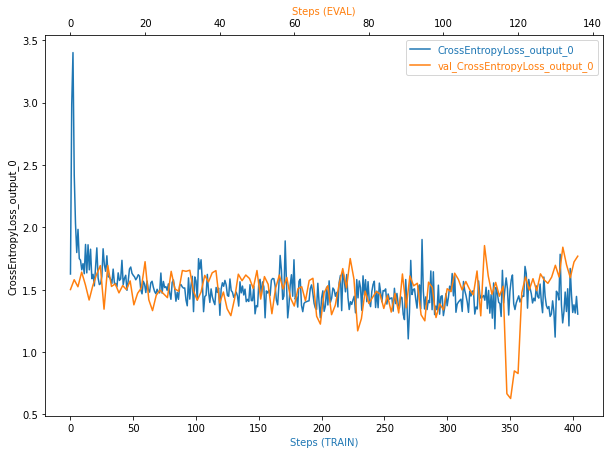

In [27]:
# Display the profiler output
plot_tensor(trial, 'CrossEntropyLoss_output_0')

The cross entropy loss tends to decrease during the execution of three epochs. It seems the model is slowly improving its ability to accurately predict the correct labels.

In [28]:
import boto3

session = boto3.session.Session()
region = session.region_name

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [29]:
# Print the latest training job's rule summary
import time
from IPython import display

%matplotlib inline

description = client.describe_training_job(TrainingJobName=job_name)
primary_status = description["TrainingJobStatus"]
secondary_status = description["SecondaryStatus"]
print("====================================================================")
print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
print("====================================================================")
for r in range(len(estimator.latest_training_job.rule_job_summary())):
    rule_summary = estimator.latest_training_job.rule_job_summary()
    print(
        rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
    )
    if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
        print(rule_summary[r]["StatusDetails"])
    print("====================================================================")
#display.clear_output(wait=True)

TrainingJobStatus:  Completed  | SecondaryStatus:  Completed
VanishingGradient :  NoIssuesFound
Overfit :  NoIssuesFound
Overtraining :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule Overtraining at step 194 resulted in the condition being met

PoorWeightInitialization :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule PoorWeightInitialization at step 0 resulted in the condition being met

LossNotDecreasing :  NoIssuesFound
LowGPUUtilization :  NoIssuesFound
ProfilerReport :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule ProfilerReport at step 49 resulted in the condition being met



Note: The analysis of the issues reported above was done in the project's report.

In [30]:
# Get direct link to the rule logs 

def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
    """Helper function to get the rule job name with correct casing"""
    return "{}-{}-{}".format(
        training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
    )


def _get_cw_url_for_rule_job(rule_job_name, region):
    return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(
        region, region, rule_job_name
    )


def get_rule_jobs_cw_urls(estimator):
    region = boto3.Session().region_name
    training_job = estimator.latest_training_job
    training_job_name = training_job.describe()["TrainingJobName"]
    rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]

    result = {}
    for status in rule_eval_statuses:
        if status.get("RuleEvaluationJobArn", None) is not None:
            rule_job_name = _get_rule_job_name(
                training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"]
            )
            result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(
                rule_job_name, region
            )
    return result


get_rule_jobs_cw_urls(estimator)['PoorWeightInitialization']

'https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=object-counting-pytorch-20-PoorWeightInitialization-65c79e40;streamFilter=typeLogStreamPrefix'

In [31]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-929738310093/object-counting-pytorch-2023-12-11-14-38-20-621/rule-output


In [32]:
!aws s3 ls {rule_output_path} --recursive

2023-12-11 15:30:00     375306 object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-12-11 15:30:00     223222 object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-12-11 15:29:55        192 object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-12-11 15:29:55        200 object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-12-11 15:29:55       1984 object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-12-11 15:29:55        127 object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-12-11 15:29:55        199 object-counting-pytorch-2023-12-11-14-38-20-621/rule-

In [33]:
!aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-929738310093/object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-929738310093/object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-929738310093/object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-929738310093/object-counting-pytorch-2023-12-11-14-38-20-621/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1

In [34]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
profiler_report_name

'ProfilerReport'

Find the ProfilerReport in the project's folder `training`

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html") # html report attached separately, but can be eventually printed here executing this code line 

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [35]:
# Load the model
print("Model artifact: ", model_data)

Model artifact:  s3://sagemaker-us-east-1-929738310093/object-counting-pytorch-2023-12-11-14-38-20-621/output/model.tar.gz


In [36]:
from sagemaker.predictor import Predictor

#jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_serializer = sagemaker.serializers.JSONSerializer()
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=json_serializer,
            deserializer=json_deserializer,
        )

In [37]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(model_data=model_data, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large', endpoint_name='object-counting-endpoint')

print("Endpoint: ", predictor.endpoint_name)

-------!Endpoint:  object-counting-endpoint


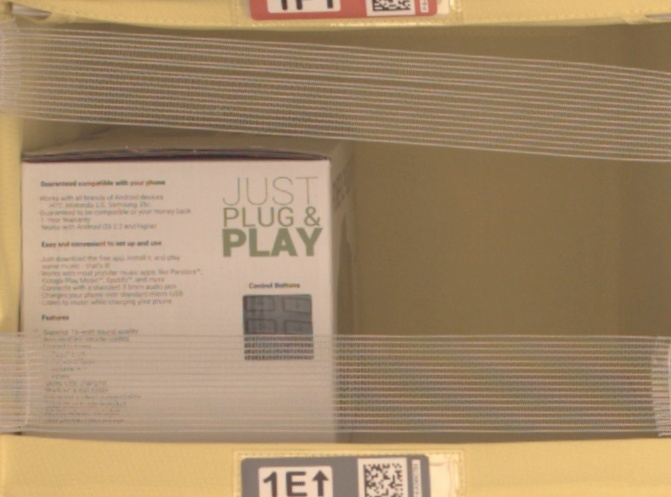

In [38]:
import requests
from PIL import Image
import io

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/10460.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [39]:
import json

response=predictor.predict(request_dict, initial_args={"ContentType": "application/json"})
print(f'Response: {response}')

labeled_predictions = list(zip(range(5), response[0]))
print("Labeled predictions: ", labeled_predictions)

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
likely_answer = "Most likely answer: there is {} object(s) in the bin".format(labeled_predictions[0][0]+1)
print(likely_answer)

Response: [[3.9974005222320557, 1.473573923110962, 0.0448618046939373, -1.289155125617981, -2.4018337726593018]]
Labeled predictions:  [(0, 3.9974005222320557), (1, 1.473573923110962), (2, 0.0448618046939373), (3, -1.289155125617981), (4, -2.4018337726593018)]
Most likely answer: there is 1 object(s) in the bin


In [40]:
# Remember to shutdown/delete the endpoint once testing is done
predictor.delete_endpoint()

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances